# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
from src.datasets import OurDataset, CocoFreeView
from src.simulation import gen_gaze, downsample
from src.noise import (add_gaussian_noise,
                                    add_elliptical_gaussian_noise,
                                    add_learned_gaussian_noise, 
                                    add_learned_gaussian_noiseV2, 
                                    add_correlated_radial_noise,
                                    add_random_center_correlated_radial_noise)



## Variacion de la distancia del sujeto con la pantalla

La variación de las distancias entre los landmarks depende de:
* El ruido del detector
* La rotación en torno a los ejes ortogonales al eje de la camara
* La distancia del objeto a la camara

The rotation can be cleaned dividing by the cosine of the yaw

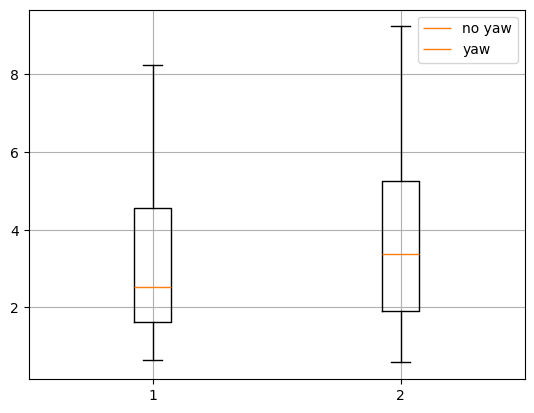

In [2]:
data = pd.read_csv('data\\Ours\\result_total_data_prosegur.csv')
    
data_t = data.groupby(['User'])
landmark_list = []
for key, value in data_t:
    landmarks = value[['XEyeLeft','YEyeLeft','XEyeRight','YEyeRight', 'Yaw']]
    if len(landmarks) > 10:
        landmark_list.append(landmarks.to_numpy())
        
v_list = []
vc_list = []
d_list = []
c_list = []

for lm in landmark_list:
    # lm = lm[np.abs(lm[:,4]) < 20]
    d = (((lm[:,0] - lm[:,2])**2 + (lm[:,1] - lm[:,3])**2)**(1/2))
    d_list.append(d)
    c = d/np.cos(np.radians(np.abs(lm[:,4])))
    c_list.append(c)
    v_list.append(d.std())
    vc_list.append(c.std())
    
plt.boxplot([v_list, vc_list], label = ['no yaw', 'yaw'])
plt.grid()
plt.legend()
pass

# Simulation Test

In [3]:
def summary(gaze):
    print('traj count: ', len(gaze))
    sample_per_traj = np.asanyarray([gaze_sample.shape[1] for gaze_sample in gaze])
    print('MIN sample per traj: ', sample_per_traj.min())
    print('MAX sample per traj: ', sample_per_traj.max())
    counts, edge_bin = np.histogram(sample_per_traj)
    bin_center = (edge_bin[1:] + edge_bin[:-1]) / 2
    rev_counts = counts[::-1]
    rev_distr = np.cumsum(rev_counts)
    distr = rev_distr[::-1]
    distr = distr/sample_per_traj.shape[0]
    
    # Plot the CDF
    plt.figure() # Create a new figure
    plt.plot(bin_center, distr)
    plt.title('Normalized Sample Count CDF per Trajectory')
    plt.xlabel('Samples per Trajectory')
    plt.ylabel('Cumulative Probability')
    plt.grid('on')
    plt.show() # Display the plot



## Loading Data

(2, 1000)
traj count:  1000
MIN sample per traj:  6
MAX sample per traj:  27


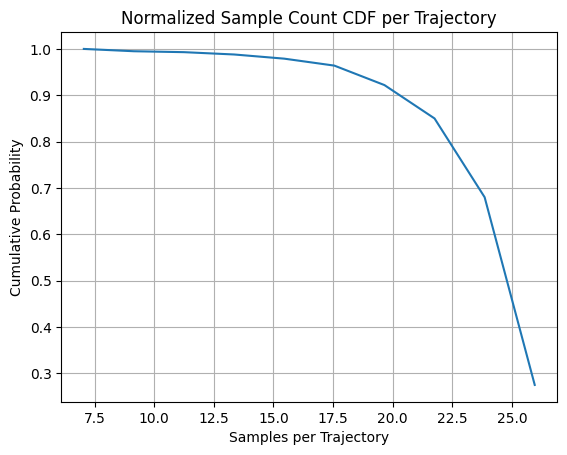

In [4]:
# index = 8
# scale = scale_vals[s_index[:20]]
# corr = corr_vals[s_index[:20]]

data = CocoFreeView()
idx = np.random.randint(0,len(data),1000)
clean_gaze = gen_gaze(data, idx,60)
# RES: (512,360)
# clean_sim_gaze = downsample(clean_gaze, down_time_step = 200)
# noisy_gaze_circ =  add_gaussian_noise(clean_gaze,data.ptoa)
# noisy_gaze_elip =  add_elliptical_gaussian_noise(clean_gaze,data.ptoa, 0.3,4.13)
# elip_sim_gaze = downsample(noisy_gaze_elip, down_time_step = 200)
# noisy_gaze_learn =  add_learned_gaussian_noise(clean_gaze, scale = .15)
# learn_sim_gaze = downsample(noisy_gaze_learn, down_time_step = 200)

# noisy_gaze_learnV2 =  add_learned_gaussian_noiseV2(clean_gaze, scale = .5)
# learnV2_sim_gaze = downsample(noisy_gaze_learnV2, down_time_step = 200)

# noisy_gaze_corr =  add_autoregressive_noise(clean_gaze, scale = .8, corr = .8)
# noisy_gaze_corr =  add_autoregressive_noise(clean_gaze, scale = .8, corr = .8)
# corr_sim_gaze = downsample(noisy_gaze_corr, down_time_step = 200)


# down_gaze = downsample(clean_gaze, down_time_step = 200)
# radial_sim_gaze = add_correlated_radial_noise(down_gaze,[840,525],1/16,
#                                               radial_corr = .5,
#                                               radial_avg_norm= 6,
#                                               radial_std=6,
#                                               center_noise_std=60,
#                                               center_corr=.7)


down_gaze = downsample(clean_gaze, down_time_step = 200)
cradial_sim_gaze, _ = add_random_center_correlated_radial_noise(down_gaze,[320//2,512//2],1/16,
                                              radial_corr = .2,
                                              radial_avg_norm= 4.13,
                                              radial_std=3.5,
                                              center_noise_std=100,
                                              center_corr=.3,
                                              center_delta_norm=300,
                                              center_delta_r=.2)


gaze_list = [
    # (clean_sim_gaze, 'clean', data.ptoa),
            #  (elip_sim_gaze, 'elip', data.ptoa),
            # (corr_sim_gaze, 'corr', data.ptoa),
            (cradial_sim_gaze, 'radial', data.ptoa),
            #  (learn_sim_gaze, 'learn', data.ptoa),
            #  (learnV2_sim_gaze, 'learnV2', data.ptoa)
             ]
summary(down_gaze)

In [6]:
gaze, scanpath, mask = gen_gaze(data, 500,60,True, True)

traj count:  62
MIN sample per traj:  1
MAX sample per traj:  15


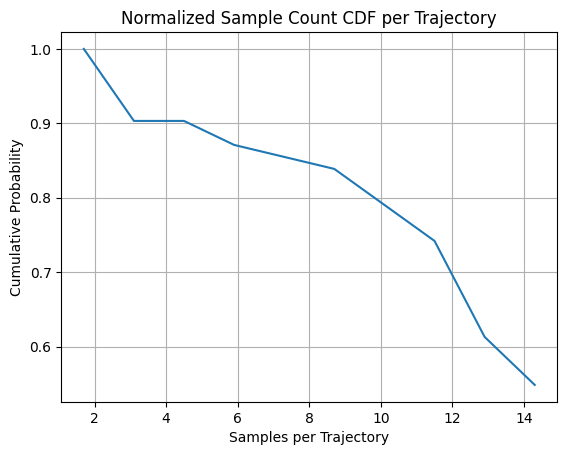

In [23]:
our_data = OurDataset()
# RES: (960,540)
our_gaze = our_data.get_eye_track(idx = range(len(our_data)))
gaze_list.append((our_gaze, 'our',None))
summary(our_gaze)

## Methods

In [6]:
def amplitude_array(gaze, ptoa=None):
    if ptoa is None:
        ptoa = 1/16
    coords = gaze[:2, :]
    return np.linalg.norm(np.diff(coords, axis=1), axis=0)*ptoa


def plot_amplitude_dist(gaze_list, label_list, ptoa_list, bin_count=30, bin_min=0, bin_max=20):
    bins = np.linspace(bin_min, bin_max, bin_count)
    for gaze, label, ptoa in zip(gaze_list, label_list, ptoa_list):
        amp = np.concat([amplitude_array(gaze_sample, ptoa)
                        for gaze_sample in gaze])
        counts, bin_edges = np.histogram(amp, bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        norm_counts = counts/counts.sum()
        plt.plot(bin_centers, norm_counts, label=label)
    plt.vlines([2], 0, 0.1, colors='red', label='scanpath_mode')
    plt.legend()
    plt.title('Amplitude Distribution in Degrees')


def compute_angles(gaze):
    coords = gaze[:2, :]
    gaze_vec = np.diff(coords, axis=1)
    return np.arctan2(gaze_vec[1], gaze_vec[0]) * 180 / np.pi


def plot_angle_distribution(gaze_list, label_list, bin_counts=30):

    for gaze, label in zip(gaze_list, label_list):
        ang = np.concatenate([compute_angles(gaze_sample)
                             for gaze_sample in gaze])
        counts, edges = np.histogram(ang, bins=bin_counts, range=(-180, 180))
        norm_counts = counts / counts.sum()
        bin_centers = (edges[:-1] + edges[1:]) / 2
        plt.plot(bin_centers, norm_counts, label=label)

    plt.xticks(
        [-180, -90, 0, 90, 180],
        ["Left", "Down", "Right", "Up", "Left"]
    )

    plt.xlabel("Orientation")
    plt.ylabel("Normalized frequency")
    plt.title("Gaze orientation histogram")
    plt.legend()


def consecutive_angles(gaze):
    coords = gaze[:2, :].T
    vec = np.diff(coords, axis=0)
    v1 = vec[:-1]
    v2 = vec[1:]
    dot_product = np.sum(v1*v2, axis=1)
    cross_product = v1[:, 0]*v2[:, 1] * v2[:, 0]*v1[:, 1]
    angles = np.arctan2(dot_product, cross_product)
    angles = angles/np.pi*180
    return angles


def plot_consecutive_angles(gaze_list, label_list, bin_counts=30):

    for gaze, label in zip(gaze_list, label_list):
        ang = np.concat([consecutive_angles(gaze_sample)
                        for gaze_sample in gaze])
        counts, edges = np.histogram(ang, bins=bin_counts, range=(-180, 180))
        norm_counts = counts / counts.sum()
        bin_centers = (edges[:-1] + edges[1:]) / 2
        plt.plot(bin_centers, norm_counts, label=label)

    plt.xticks([-180, -90, 0, 90, 180])

    plt.xlabel("Orientation")
    plt.ylabel("Normalized frequency")
    plt.title("Angle Between Samples")
    plt.legend()


def autocorrelation(gaze, max_len=7):
    coords = gaze[:2, :]
    amplitudes = np.linalg.norm(coords, axis=0)
    signal = amplitudes - np.mean(amplitudes)
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]
    return autocorr[:max_len]


def plot_autocorrelation(gaze_list, label_list, max_len=7):
    for gaze, label in zip(gaze_list, label_list):
        autocorr = np.vstack([autocorrelation(gaze_sample, max_len)
                             for gaze_sample in gaze if gaze_sample.shape[1] > max_len])
        mean_autocorr = autocorr.mean(axis=0)
        std_autocorr = autocorr.std(axis=0)
        line_plot = plt.plot(mean_autocorr, label=label)
        line_color = line_plot[0].get_color()
        plt.fill_between(
            range(len(mean_autocorr)),
            mean_autocorr - std_autocorr,
            mean_autocorr + std_autocorr,
            color=line_color,
            alpha=0.2,
            label='Standard Deviation'
        )
    plt.title('Autocorrelation of Amplitudes')
    plt.xlabel('Lag (k)')
    plt.ylabel('Normalized Correlation')
    plt.grid(True)
    plt.ylim(-1.1, 1.1)
    plt.legend()
    plt.hlines([0], xmin=0, xmax=max_len - 1, colors='red')


def compute_vector_dist(vec_list, ptoa=None,  hist_min = -10, hist_max = 10, hist_bins = 30):
    if ptoa is None:
        ptoa = 1/16
    vec = np.concatenate(vec_list, axis=1)
    vec = vec * ptoa
    edges = np.linspace(hist_min, hist_max, hist_bins)

    counts, x_edges, y_edges = np.histogram2d(vec[0], vec[1], bins=edges)
    return counts, x_edges, y_edges


def plot_vector_dist(gaze_list, ptoa_list, label_list, hist_min= -20, hist_max=20, hist_bins=50, arrow = False):
    """
    Plots the 2D distribution of vectors for multiple datasets.

    gaze_list, ptoa_list, and label_list must be the same length.
    """
    fig, axis = plt.subplots(1, len(gaze_list), figsize=(16, 8), squeeze=False)
    axis = axis.flatten() # Ensure axis is always an iterable array

    for i, (gaze, ptoa, label) in enumerate(zip(gaze_list, ptoa_list, label_list)):
        counts, x_edges, y_edges = compute_vector_dist(gaze, ptoa, hist_min, hist_max, hist_bins)
        
        # Avoid division by zero if counts is all zero
        if counts.sum() > 0:
            counts = counts / counts.sum()

        blurred_counts = counts
        im = axis[i].imshow(
            blurred_counts.T,  # Transpose for conventional X/Y axis alignment
            cmap='gray_r',
            origin='lower',  # Put the origin (0,0) at the bottom-left
            extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]
        )
        
        fig.colorbar(im, ax=axis[i], label='Probability Density') 
        
        if arrow:
            # CORRECTED LINE: dx=1, dy=0 to go from (-1,0) to (0,0)
            axis[i].arrow(-1, 0, 1, 0, head_width=0.1, head_length=0.1, fc='red', ec='red', length_includes_head=True)

        axis[i].set_title(f'2D Histogram of Vectors from {label}')
        axis[i].set_xlabel('Scaled X Difference')
        axis[i].set_ylabel('Scaled Y Difference')

    plt.tight_layout() # Adjust subplots to fit in figure area
    plt.show()

def calculate_relative_vectors(vec):
    """
    Transforms movement vectors to be relative to the preceding vector.

    For each pair of consecutive movement vectors (v1, v2), it transforms v2
    into a new coordinate system where v1 is the vector (1, 0).

    Args:
        gaze_trajectory (np.ndarray): An array of shape (2, N) with x and y coordinates.

    Returns:
        np.ndarray: An array of shape (2, M) containing the transformed vectors.
    """

    v1 = vec[:, :-1]
    v2 = vec[:, 1:]

    norm_v1 = np.linalg.norm(v1, axis=0)

    valid_indices = norm_v1 > 1e-9
    v1 = v1[:, valid_indices]
    v2 = v2[:, valid_indices]
    norm_v1 = norm_v1[valid_indices]

    angle_v1 = np.arctan2(v1[1, :], v1[0, :])

    cos_angle = np.cos(-angle_v1)
    sin_angle = np.sin(-angle_v1)

    new_x = (v2[0, :] * cos_angle - v2[1, :] * sin_angle) / norm_v1
    new_y = (v2[0, :] * sin_angle + v2[1, :] * cos_angle) / norm_v1

    return np.vstack((new_x, new_y))


# Sim + DS + N vs Ours
* Deepgaze lll Stats 

### Amplitude Distribution

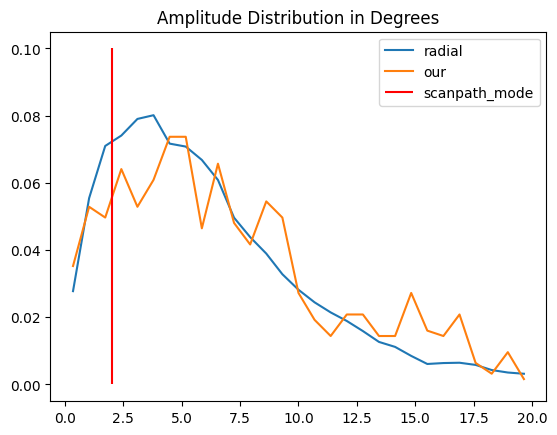

In [24]:
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])
plt.show()

### Orientation Distribution

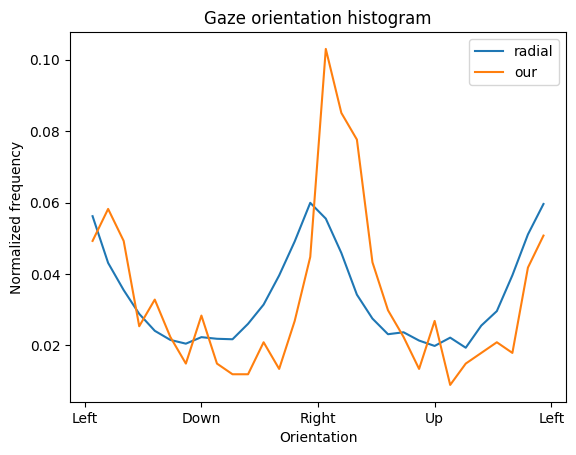

In [25]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

### Angles between saccades

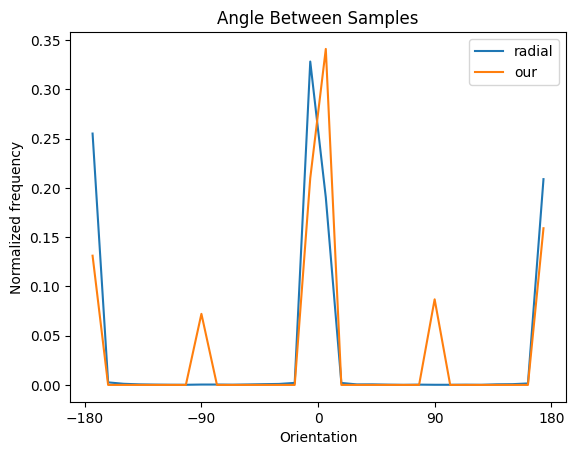

In [26]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

### Autocorrelation

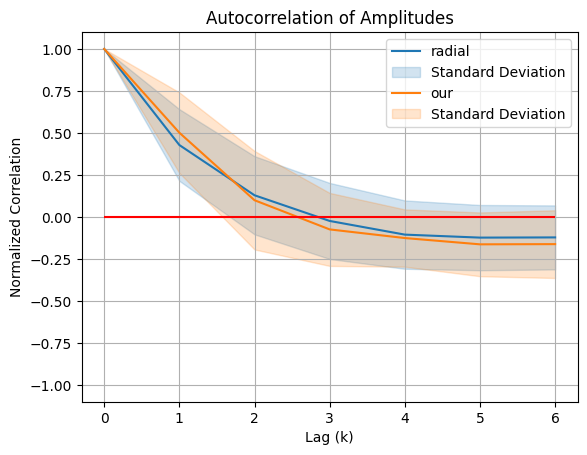

In [27]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])

### Vector Distribution

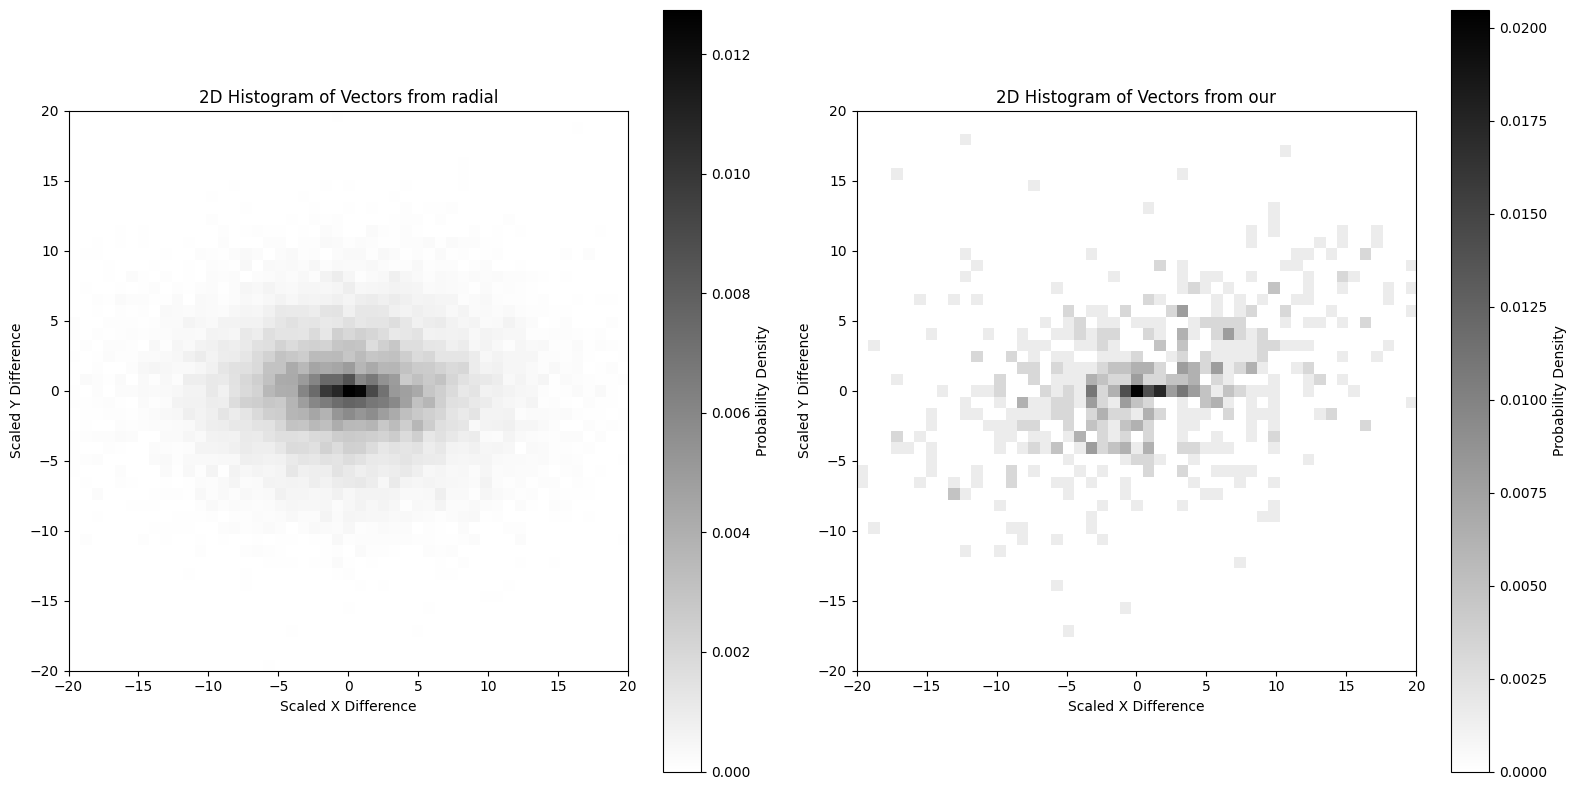

In [28]:
# circ_sim_vec = [np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in circ_sim_gaze]
# elip_sim_vec = [np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in elip_sim_gaze]
# our_vec = [np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in our_gaze]

plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

### Relative Distribution

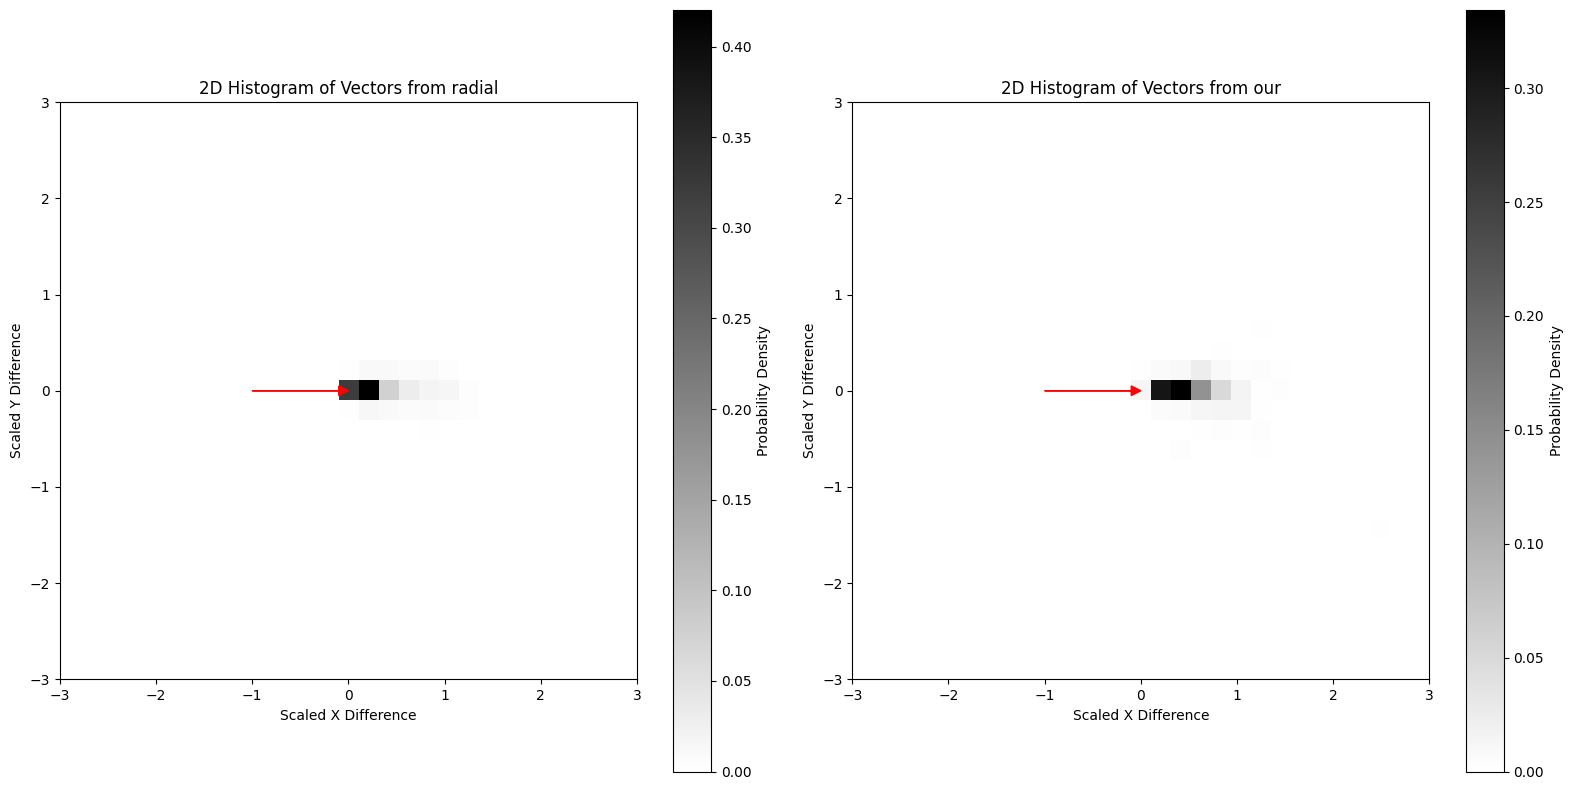

In [31]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()

# Sim + Downsample vs Real + Downsample

* Deepgaze lll Stats
* Distance between samples

In [13]:
#TODO Process ETRA, to verify saccade duration

# Sim vs Real
* Scanpath: Comparison as DeepGaze lll
* Saccade Duration